In [1]:
!pip install gtsam
!pip install transforms3d

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import gtsam
import numpy as np
from transforms3d.quaternions import quat2mat
import matplotlib.pyplot as plt

In [3]:
def read_g2o_3d(file_path):
    poses = []
    edges = []
    
    with open(file_path, 'r') as f:
        lines = f.readlines()
        
        for line in lines:
            data = line.strip().split()
            
            if data[0] == 'VERTEX_SE3:QUAT':
                # Parse vertex
                idx = int(data[1])
                x = float(data[2])
                y = float(data[3])
                z = float(data[4])

                R = (float(data[8]), float(data[5]),float(data[6]),float(data[7]))
                # Append pose to list
                poses.append((idx, x, y, z, R))
                
            elif data[0] == 'EDGE_SE3:QUAT':
                # Parse edge
                i = int(data[1])
                j = int(data[2])
                x = float(data[3])
                y = float(data[4])
                z = float(data[5])
                R = (float(data[9]), float(data[6]),float(data[7]),float(data[8]))

                info = np.zeros((6,6))
                c=10
                for ii in range(6):
                  for jj in range(6):
                    if ii>jj: continue
                    info[ii,jj] = data[c]
                    c+=1
                info += info.T - np.eye(6)*np.diag(info)
    
                # Compute covariance matrix
                cov = np.linalg.inv(info)
                
                # Append edge to list
                edges.append((i, j, x, y, z, R, cov))
                
    return np.asarray(poses), np.asarray(edges)


In [4]:
poses, edges = read_g2o_3d(f'/content/drive/MyDrive/SLAM_HW4/parking-garage.g2o')

<ipython-input-3-0c0fcc5e4820>:46: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.asarray(poses), np.asarray(edges)


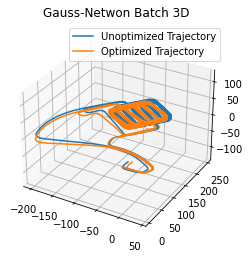

In [5]:
graph = gtsam.NonlinearFactorGraph()
init = gtsam.Values()

for pose in poses:
    r = gtsam.Rot3.Quaternion(pose[4][0], pose[4][1], pose[4][2], pose[4][3])
    t = gtsam.Point3(pose[1],pose[2],pose[3])
    init.insert(int(pose[0]),gtsam.Pose3(r,t))
    

prior_model = gtsam.noiseModel.Diagonal.Variances(np.array([0.3, 0.3, 0.3,0.1,0.1, 0.1]))
graph.add(gtsam.PriorFactorPose3(0, init.atPose3(0), prior_model))

for edge in edges:
    r = gtsam.Rot3.Quaternion(edge[5][0], edge[5][1], edge[5][2], edge[5][3])
    t = gtsam.Point3(edge[2],edge[3],edge[4])
    model = gtsam.noiseModel.Gaussian.Covariance(edge[6])
    graph.add(gtsam.BetweenFactorPose3(edge[0],edge[1],gtsam.Pose3(r,t),model))

params = gtsam.GaussNewtonParams()
optimizer = gtsam.GaussNewtonOptimizer(graph, init, params)
result = optimizer.optimize()

opt_poses = gtsam.utilities.extractPose3(result)

ax = plt.axes(projection='3d')
plt.plot(poses[:,1],poses[:,2],poses[:,3])
plt.plot(opt_poses[:,9],opt_poses[:,10],opt_poses[:,11])
plt.title('Gauss-Netwon Batch 3D')
plt.legend(['Unoptimized Trajectory', 'Optimized Trajectory'])

X = opt_poses[:,9]
Y = opt_poses[:,10]
Z = opt_poses[:,11]
max_range = np.array([X.max()-X.min(), Y.max()-Y.min(), Z.max()-Z.min()]).max() / 2.0

mid_x = (X.max()+X.min()) * 0.5
mid_y = (Y.max()+Y.min()) * 0.5
mid_z = (Z.max()+Z.min()) * 0.5
ax.set_xlim(mid_x - max_range, mid_x + max_range)
ax.set_ylim(mid_y - max_range, mid_y + max_range)
ax.set_zlim(mid_z - max_range, mid_z + max_range)

plt.show()

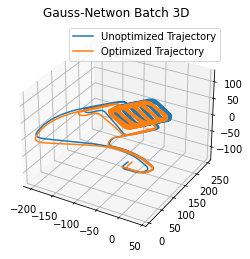

In [7]:
graph = gtsam.NonlinearFactorGraph()
init = gtsam.Values()

params = gtsam.ISAM2Params()
isam = gtsam.ISAM2(params)

for ii, pose in enumerate(poses):
  if ii==0:
    r = gtsam.Rot3.Quaternion(pose[4][0], pose[4][1], pose[4][2], pose[4][3])
    t = gtsam.Point3(pose[1],pose[2],pose[3])
    init.insert(int(pose[0]),gtsam.Pose3(r,t))
    prior_model = gtsam.noiseModel.Diagonal.Variances(np.array([0.3, 0.3, 0.3,0.1,0.1, 0.1]))
    graph.add(gtsam.PriorFactorPose3(0, init.atPose3(0), prior_model))
  else:
    init.insert(int(pose[0]),result.atPose3(ii-1))

  for edge in edges:
    if edge[1]==ii:
      r = gtsam.Rot3.Quaternion(edge[5][0], edge[5][1], edge[5][2], edge[5][3])
      t = gtsam.Point3(edge[2],edge[3],edge[4])
      model = gtsam.noiseModel.Gaussian.Covariance(edge[6])
      graph.add(gtsam.BetweenFactorPose3(edge[0],edge[1],gtsam.Pose3(r,t),model))

  isam.update(graph,init)
  result = isam.calculateEstimate()
  graph.resize(0)
  init.clear()

opt_poses = gtsam.utilities.extractPose3(result)

ax = plt.axes(projection='3d')
plt.plot(poses[:,1],poses[:,2],poses[:,3])
plt.plot(opt_poses[:,9],opt_poses[:,10],opt_poses[:,11])
plt.title('ISAM2 3D')
plt.legend(['Unoptimized Trajectory', 'Optimized Trajectory'])

X = opt_poses[:,9]
Y = opt_poses[:,10]
Z = opt_poses[:,11]
max_range = np.array([X.max()-X.min(), Y.max()-Y.min(), Z.max()-Z.min()]).max() / 2.0

mid_x = (X.max()+X.min()) * 0.5
mid_y = (Y.max()+Y.min()) * 0.5
mid_z = (Z.max()+Z.min()) * 0.5
ax.set_xlim(mid_x - max_range, mid_x + max_range)
ax.set_ylim(mid_y - max_range, mid_y + max_range)
ax.set_zlim(mid_z - max_range, mid_z + max_range)

plt.show()